In [1]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 5.0 MB/s eta 0:00:00


In [2]:
import torch
from torch import cuda
from datasets import load_dataset
from transformers import AutoTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from transformers import TrainerCallback
from peft import LoraConfig, get_peft_model, TaskType
import wandb

In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
print(device)

cuda


In [5]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
ds = load_dataset("glue","sst2")
def tokenize(batch):
    return tokenizer(batch['sentence'], padding='max_length', truncation=True)
ds = ds.map(tokenize, batched=True)
ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [7]:
train_ds = ds['train']
train_test_split = train_ds.train_test_split(test_size=0.2)
train_ds = train_test_split['train']
test_ds = train_test_split['test']
val_ds = ds['validation']

In [8]:
# train_ds = train_ds.select(range(100))
# test_ds = test_ds.select(range(100))
# val_ds = val_ds.select(range(100))
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

# print(test_ds)
# print(val_ds)

53879
13470
872


In [9]:
train_acc = []
class TrainAccCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # Perform a prediction on the training set
        train_predictions = trainer.predict(train_ds)
        train_preds = train_predictions.predictions.argmax(axis=-1)
        train_labels = train_predictions.label_ids
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_acc.append(train_accuracy)
        print(f"Training Accuracy after epoch {state.epoch}: {train_accuracy:.4f}")


In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")
wandb.login(key = secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
training_args = {
    "output_dir": "./output",
    "overwrite_output_dir": True,
    "num_train_epochs": 4,
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "learning_rate": 1e-5,
    "weight_decay": 0.01,
    "load_best_model_at_end": True,
    "metric_for_best_model": "accuracy",
    "eval_strategy": "epoch",
    "save_strategy": "epoch",
    "logging_strategy": "epoch",
}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

training_args = TrainingArguments(**training_args)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"]
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, eval_dataset=val_ds, compute_metrics=compute_metrics, callbacks=[TrainAccCallback()])


trainable params: 1,034,498 || all params: 125,681,668 || trainable%: 0.8231


In [12]:
trainer.train()
trainer.save_model("./best_roberta_model")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: rkalich2 (rkalich2-johns-hopkins-university). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240906_131627-6g8hxt7k
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./output
wandb: ⭐️ View project at https://wandb.ai/rkalich2-johns-hopkins-university/huggingface
wandb: 🚀 View run at https://wandb.ai/rkalich2-johns-hopkins-university/huggingface/runs/6g8hxt7k


Epoch,Training Loss,Validation Loss,Accuracy
1,0.363700,0.241080,0.907110
2,0.263900,0.225353,0.916284
3,0.252400,0.219414,0.926606
4,0.244400,0.217991,0.925459


Training Accuracy after epoch 1.0: 0.9097
Training Accuracy after epoch 2.0: 0.9175
Training Accuracy after epoch 3.0: 0.9209
Training Accuracy after epoch 4.0: 0.9210


In [13]:
test_results = trainer.evaluate(eval_dataset=test_ds, metric_key_prefix="test")

In [14]:
log_history = trainer.state.log_history


val_acc = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]


In [15]:
import pickle
log_history_file = 'log_history.pkl'
with open(log_history_file, 'wb') as f:
    pickle.dump(log_history, f)

[0.9097236400081664, 0.9175374450156832, 0.9208782642588021, 0.9210081850071457]
[0.9071100917431193, 0.9162844036697247, 0.926605504587156, 0.9254587155963303]


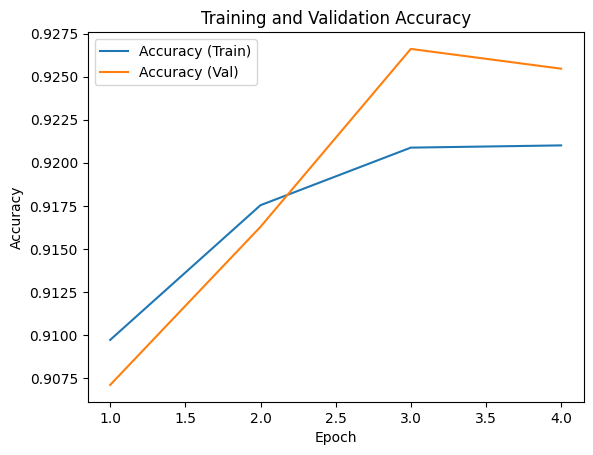

In [16]:
print(train_acc)
print(val_acc)
n = 4
epochs = [i for i in range(1,n+1)]


plt.plot(epochs, train_acc, label='Accuracy (Train)')
plt.plot(epochs, val_acc, label='Accuracy (Val)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('roberta_with_lora.png')

In [17]:
print(test_results["test_accuracy"])

0.9152190051967335
